# Sort spikes and make bout/motif rasters
Bird z_w12m7_20
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/home/finch/repos/npy-matlab'

In [2]:
import pickle

In [3]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [4]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-12-01 15:08:39,844 root         INFO     all modules loaded


### Session parameters and raw files

In [5]:
reload(et)

bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [6]:
reload(et)
sess_par = {'bird': 'z_w12m7_20',
           'sess': '2020-11-04',
           'probe': 'probe_0',
           'sort': 'sort_4'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [7]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx'

In [8]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-12-01 15:08:40,189 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20', 'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx', 'kwik': '/experiment/z_w12m7_20/sglx/kwik/2020-11-04', 'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/z_w12m7_20/sglx/msort/2020-11-04', 'ksort': '/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/sort_4', 'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/sort_4'}, 'files': {'par': '/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/sort_4/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/rig.json', 'kwd': '/experiment/z_w12m7_20/

['2500r250a_3500_dir_g0', '2500r250a_3500_dir_g1', '2500r250a_3500_dir_g2']

In [9]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # dir_g0 is the one that has bouts of song
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [10]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2500r250a_3500_dir_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/2500r250a_3500_dir_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
  'kwik': '/experiment/z_w12m7_20/sglx/kwik/2020-11-04/2500r250a_3500_dir_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
  'tmp': '/experiment/tmp/tmp/2500r250a_3500_dir_g0',
  'msort': '/experiment/tmp/z_w12m7_20/sglx/msort/2020-11-04/2500r250a_3500_dir_g0',
  'ksort': '/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/sort_4',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4'},
 'files': {'par': '/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/params.json',
  '

In [11]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0'}

In [12]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0/2500r250a_3500_dir_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/2500r250a_3500_dir_g0_imec0/2500r250a_3500_dir_g0_t0.imec0.ap.meta']}

In [13]:
files_pd = pd.DataFrame(sgl_files)

In [14]:
files_pd

nidq  \
0  /mnt/sphere/speech_bci/raw_data/z_w12m7_20/202...   

                                                lf_0  \
0  /mnt/sphere/speech_bci/raw_data/z_w12m7_20/202...   

                                                ap_0  
0  /mnt/sphere/speech_bci/raw_data/z_w12m7_20/202...

### load epoch files

In [15]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


### do the sync
- get the sync events from the recordings 
- write the npy sync event files

In [16]:
from ceciestunepipe.util import sglxsync as syn

In [17]:
syn.get_syn_pattern(run_recordings, exp_struct, 'wav', force=False)

2021-12-01 15:08:45,949 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2021-12-01 15:08:45,958 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_dict.pkl


{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_evt.npy',
 'path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_dict.pkl',
 'evt_arr': memmap([[     7198,     19698,     32197, ..., 191017532, 191030032,
          191042532],
         [       -1,         1,        -1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         7.64209524e+03, 7.64209528e+03, 7.64209532e+03])}

##### get the syn patterns for all of the signals

In [18]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: syn.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2021-12-01 15:08:46,982 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2021-12-01 15:08:46,985 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/nidq_sync_dict.pkl
2021-12-01 15:09:00,366 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2021-12-01 15:09:00,367 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/lf_0_sync_dict.pkl
2021-12-01 15:09:01,816 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2021-12-01 15:09:01,817 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/ap_0_sync_dict.pkl
2021-12-01 15:09:01,898 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2021-12-01 15:09:01,900 ceciestunepipe.util.sglxsync INFO     loading

In [19]:
all_syn_dict['wav']

{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_evt.npy',
 'path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_dict.pkl',
 'evt_arr': memmap([[     7198,     19698,     32197, ..., 191017532, 191030032,
          191042532],
         [       -1,         1,        -1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         7.64209524e+03, 7.64209528e+03, 7.64209532e+03])}

#### do the synchronization usin the syn dict

In [20]:
from scipy.interpolate import interp1d

### quickly test this sync

### get all of the streams syncched to a reference_stream

In [21]:
ref_stream = 'ap_0'
syn.sync_all(all_syn_dict, 'ap_0', force=False)

2021-12-01 15:09:02,110 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2021-12-01 15:09:02,111 ceciestunepipe.util.sglxsync INFO      synch nidq...
2021-12-01 15:09:02,199 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2021-12-01 15:09:02,239 ceciestunepipe.util.sglxsync INFO      synch wav...


In [22]:
all_syn_dict['wav']

{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_evt.npy',
 'path': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_sync_dict.pkl',
 'evt_arr': memmap([[     7198,     19698,     32197, ..., 191017532, 191030032,
          191042532],
         [       -1,         1,        -1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         7.64209524e+03, 7.64209528e+03, 7.64209532e+03]),
 't_p': memmap([6.58613147e-05, 1.05858637e-04, 1.45855959e-04, ...,
         7.64218187e+03, 7.64218191e+03, 7.64218195e+03])}

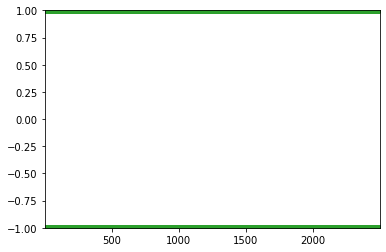

In [23]:
n_periods = 5000

# L_f against t prime
t_p_lf = all_syn_dict['lf_0']['t_p']
t_primes = t_p_lf[all_syn_dict['lf_0']['evt_arr'][0,:n_periods]]
t_naive = all_syn_dict['lf_0']['t_0'][all_syn_dict['lf_0']['evt_arr'][0,:n_periods]]
edges = all_syn_dict['lf_0']['evt_arr'][1, :n_periods]

t_0 = all_syn_dict['ap_0']['t_0'][all_syn_dict['ap_0']['evt_arr'][0,:n_periods]]
edges_0 = all_syn_dict['ap_0']['evt_arr'][1, :n_periods]

plt.plot(t_primes, edges, '*')

plt.plot(t_0, edges_0, '.')

plt.plot(t_naive, edges, '+')

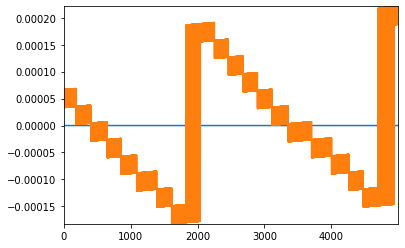

In [24]:
plt.plot(t_primes - t_0)
plt.plot(t_naive - t_0)

## Find motifs with template matching
- The mic stream comes from the mic, saved in sglx_pre-process
- A template is marked in that file
- A template matching runs over the whole file
- Manual curation selects the candidates

In [23]:
from ceciestunepipe.util.sound import spectral as sp

In [24]:
mic_s_f, mic_stream = wavfile.read(mic_file_name)

In [25]:
mic_stream

array([-40, 229, 381, ..., 534, 415, 107], dtype=int16)

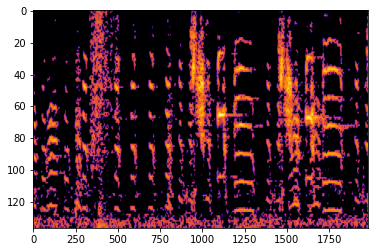

In [26]:
f, t, s = sp.ms_spectrogram(mic_stream[300000:350000], mic_s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

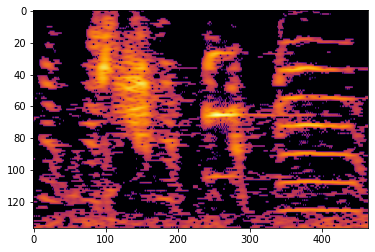

In [32]:
temp_start_s = 12.85
temp_len_s = 0.485

n_window = 512
temp_start_sample = int(temp_start_s * mic_s_f)
temp_end_sample = temp_start_sample + int(mic_s_f * temp_len_s)

template = mic_stream[temp_start_sample: temp_end_sample]

f, t, s = sp.ms_spectrogram(template, mic_s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [33]:
template.shape

(12125,)

In [35]:
s_f_khz = int((all_syn_dict['wav']['s_f'] * 0.001)) * 1000

def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

In [36]:
def match_template(x, template, s_f, f_min=300, f_max=7000, n_window=128, threshold=None):
    # get the spectrogram of all of the signal
    # get the differences along the time axis
    # find peaks
    # if threshold is none, compute a reference that is the self-similarity of the pattern when shifted 20 ms
    
    # compute the difference between the template and the spectrogram
    
    # very inefficient (and memory consuming)
    logger.info('Getting spectrogram of the whole mic channel')
    
    f, t_all, s_all = sp.ms_spectrogram(x, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    f, t_temp, s_temp = sp.ms_spectrogram(template, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    if threshold is None:
        logger.info('no threhold was entered, will set it from self-similarity of pattern shifted 20ms')
        threshold = spectral_diff(s_temp[:,15:], s_temp[:,:-15])
        logger.info('threshold is {}'.format(threshold))
    
    n_s = s_temp.shape[1]
    n_a = s_all.shape[1]
    
    logger.info('getting spectral differences')
    dist_t = np.array([spectral_diff(s_temp, 
                                     s_all[:, i: i + n_s]) for i in range(n_a - n_s)])
    
    # make positive to find peaks
    inv_dist_t = 1 - dist_t
    inv_thresh = 1 - threshold
    
    peaks = signal.find_peaks(inv_dist_t, height=inv_thresh, distance=int(n_s*0.7))
    
    return peaks, s_temp, s_all, dist_t


p, s_temp, s_all, dist_t = match_template(mic_stream.flatten(), template, s_f_khz)

2021-10-31 00:20:52,865 root         INFO     Getting spectrogram of the whole mic channel
2021-10-31 00:21:28,476 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2021-10-31 00:21:28,477 root         INFO     threshold is 0.008977126919760367
2021-10-31 00:21:28,478 root         INFO     getting spectral differences


2021-10-31 01:08:50,157 root         INFO     plotting candidates
<ipython-input-37-37e1cbd6e5fa>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


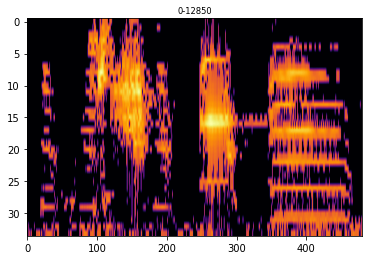

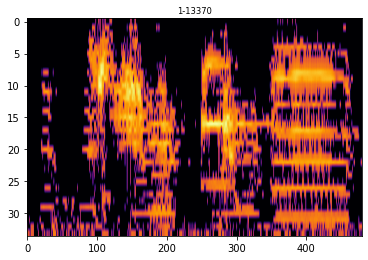

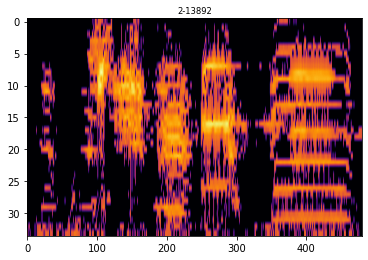

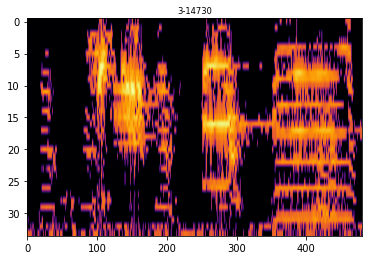

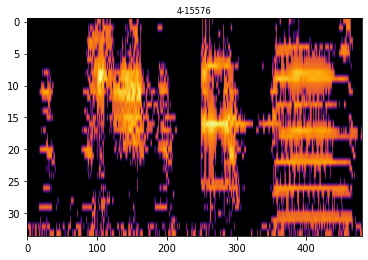

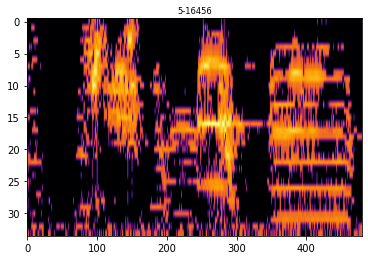

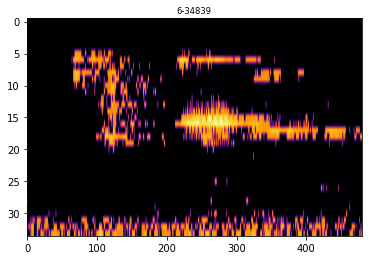

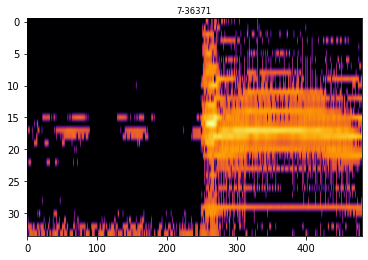

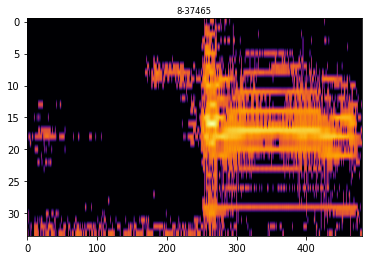

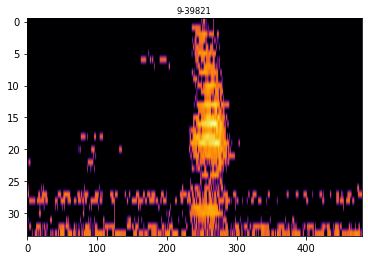

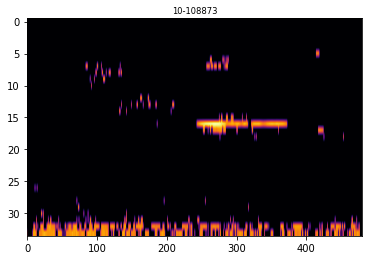

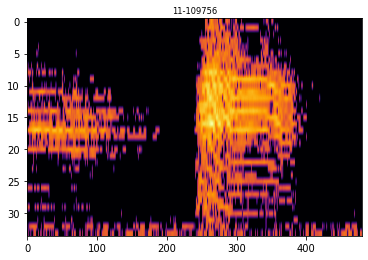

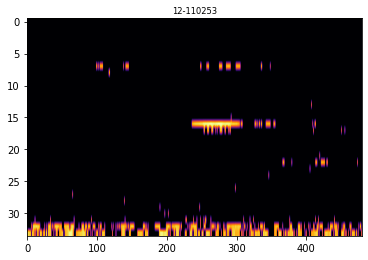

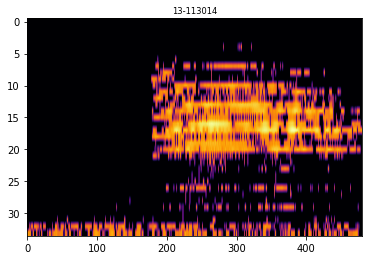

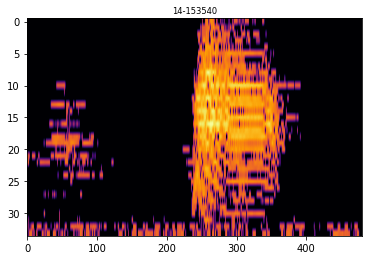

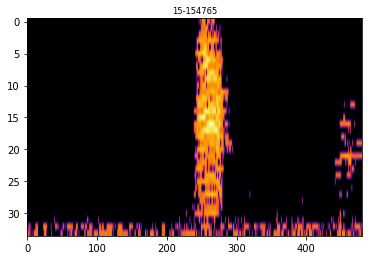

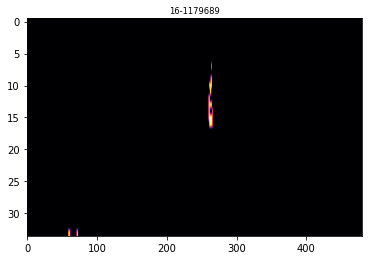

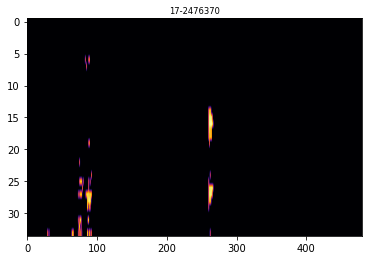

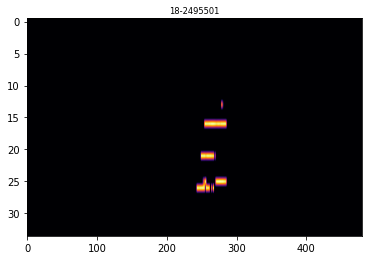

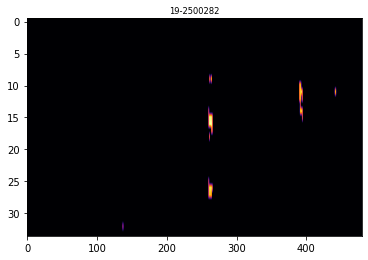

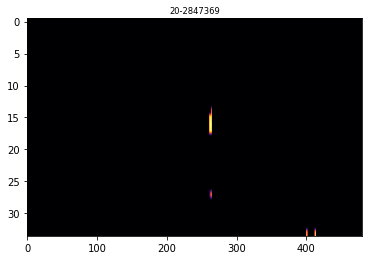

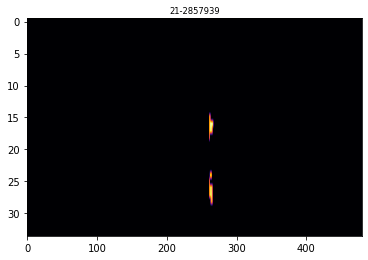

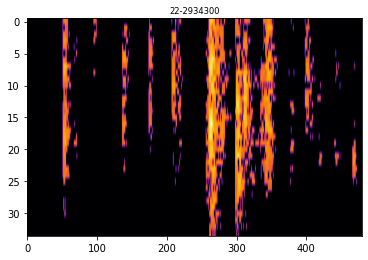

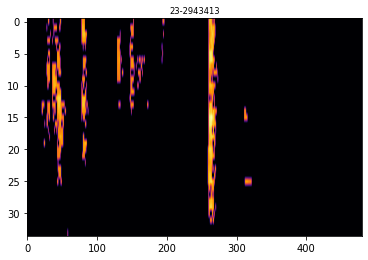

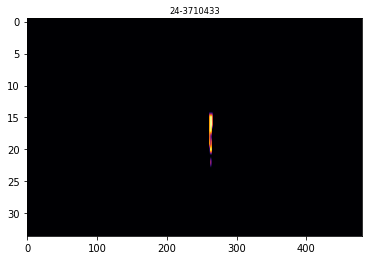

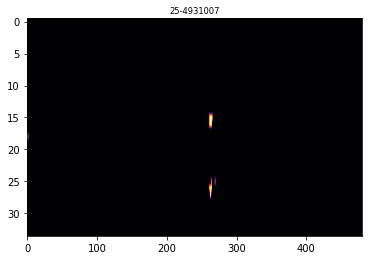

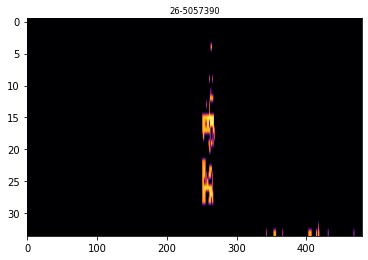

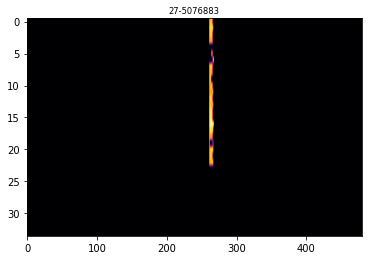

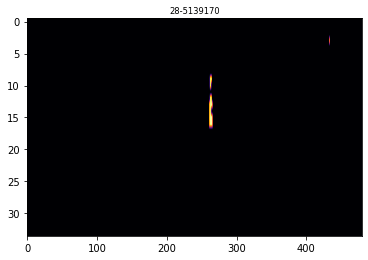

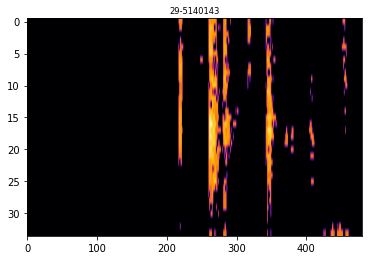

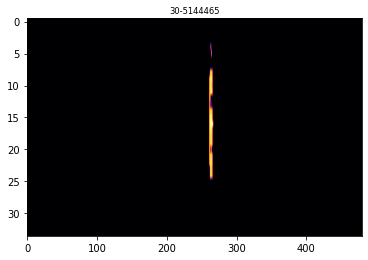

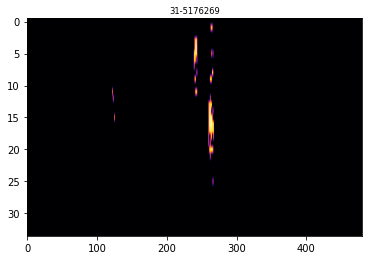

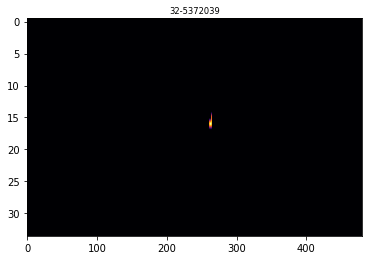

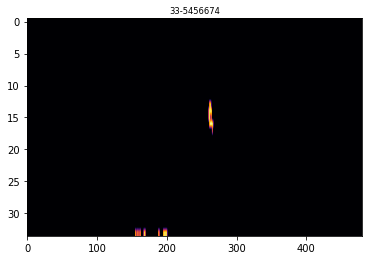

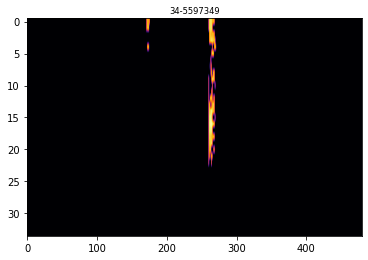

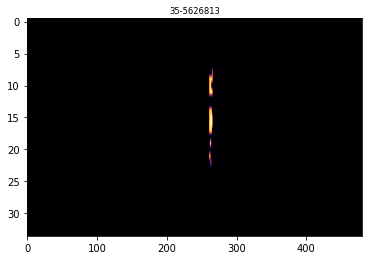

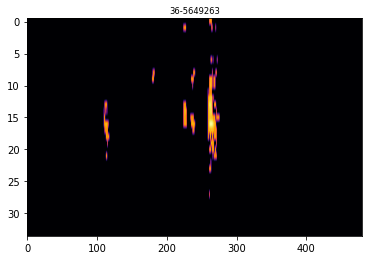

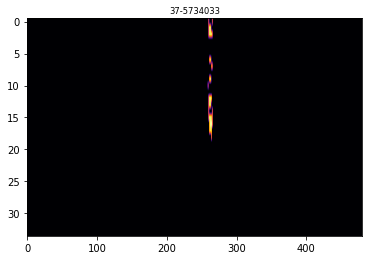

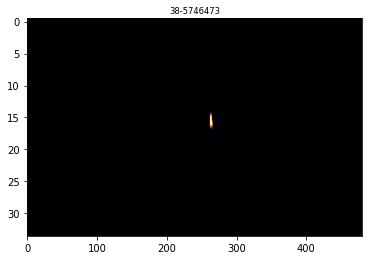

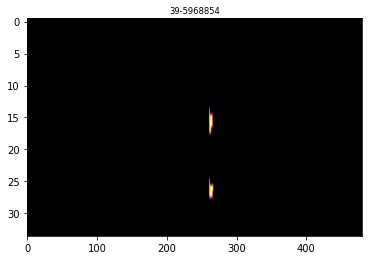

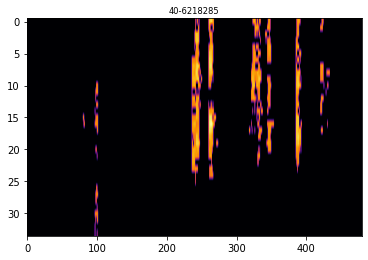

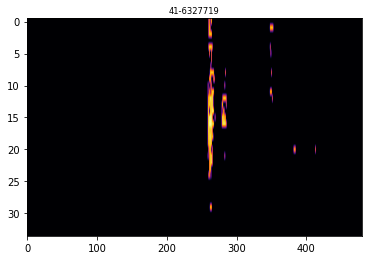

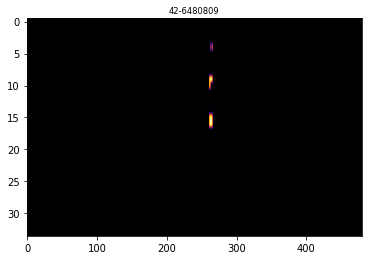

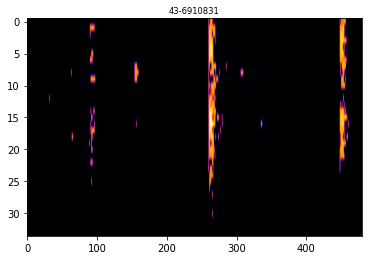

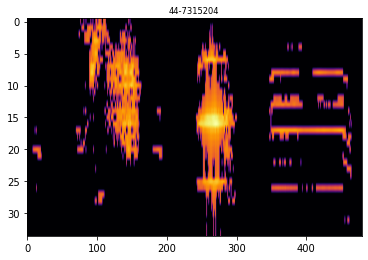

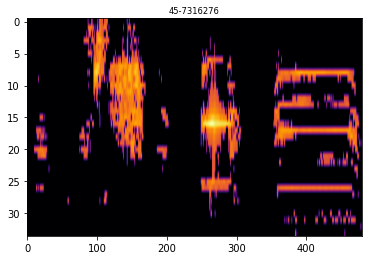

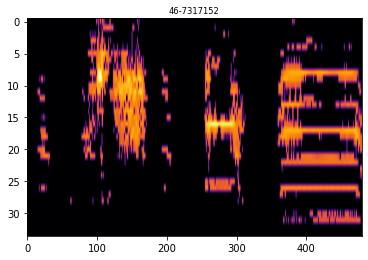

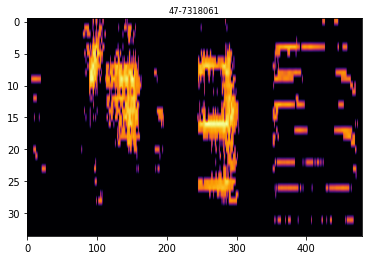

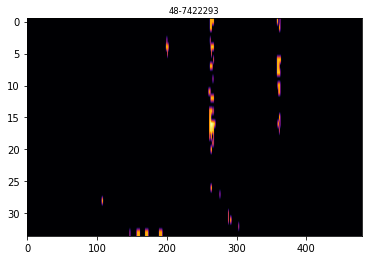

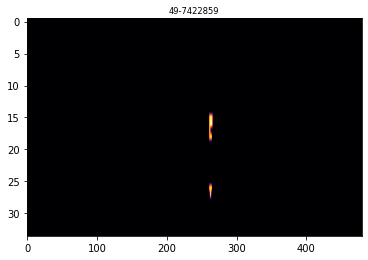

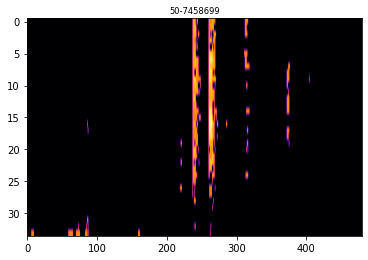

In [37]:
logger.info('plotting candidates')
for i, peak in enumerate(p[0]):
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

### Manually curate and confirm

In [38]:
curated_peaks = np.array([0, 1, 2, 3, 4, 5, 44, 45, 46, 47]).astype(np.int)
curated_peaks

<ipython-input-38-d130e0aa590b>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curated_peaks = np.array([0, 1, 2, 3, 4, 5, 44, 45, 46, 47]).astype(np.int)


array([ 0,  1,  2,  3,  4,  5, 44, 45, 46, 47])

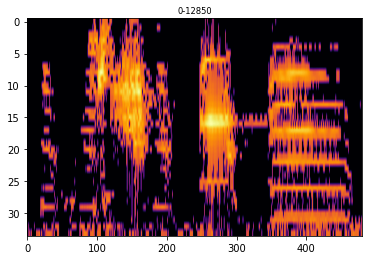

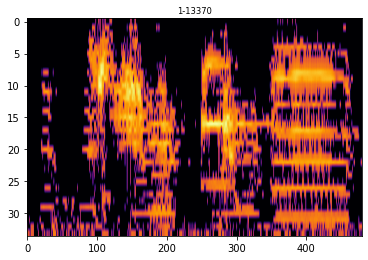

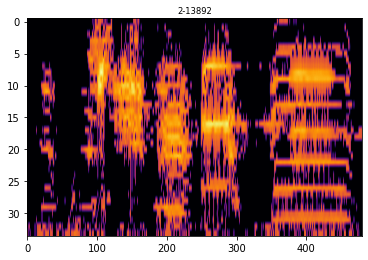

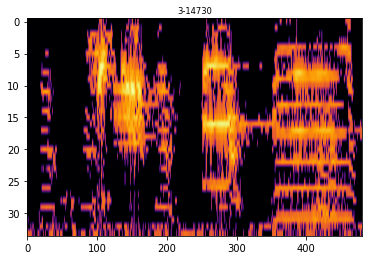

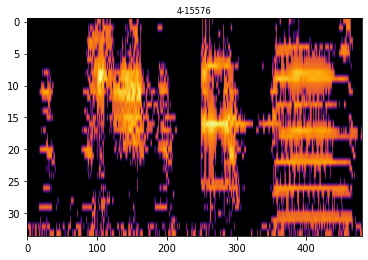

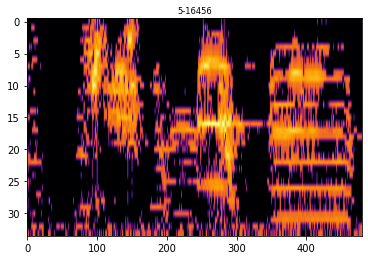

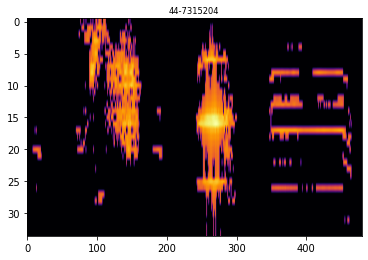

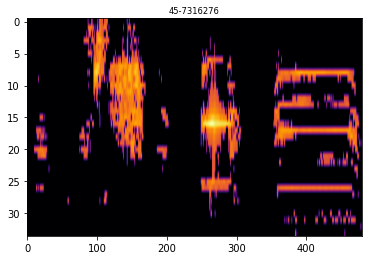

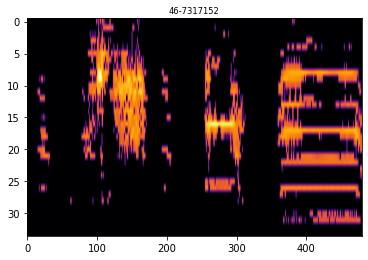

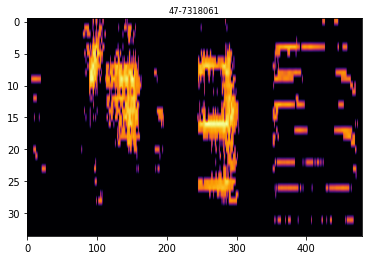

In [39]:
for i in curated_peaks:
    peak = p[0][i]
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

### Manual mot, syl parsing

In [40]:
# make a mot_arr similar to the bout_arr with start:end
hand_mot_arr_s = np.array([[p[0][i], p[0][i] + s_temp.shape[1]] for i in curated_peaks])*0.001
#hand_mot_arr = (hand_mot_arr_ms * mic_s_f * 0.001).astype(np.int64)
hand_mot_arr_s

array([[  12.85 ,   13.33 ],
       [  13.37 ,   13.85 ],
       [  13.892,   14.372],
       [  14.73 ,   15.21 ],
       [  15.576,   16.056],
       [  16.456,   16.936],
       [7315.204, 7315.684],
       [7316.276, 7316.756],
       [7317.152, 7317.632],
       [7318.061, 7318.541]])

In [172]:
hand_mot_list_s = [[12.869, 13.320], [13.391, 13.843], [13.910, 14.364], [14.747, 15.204], [15.593, 16.053],
                          [16.448, 16.931], [7315.206, 7315.679], [7316.284, 7316.759], [7317.161, 7317.643], [7318.061, 7318.548]
                 ]
hand_mot_arr_s = np.array(hand_mot_list_s)
hand_mot_arr_s

array([[  12.869,   13.32 ],
       [  13.391,   13.843],
       [  13.91 ,   14.364],
       [  14.747,   15.204],
       [  15.593,   16.053],
       [  16.448,   16.931],
       [7315.206, 7315.679],
       [7316.284, 7316.759],
       [7317.161, 7317.643],
       [7318.061, 7318.548]])

In [193]:
hand_syl_dict={}
hand_syl_dict['a'] = [[12.869, 12.895], [13.391, 13.415], [13.910, 13.938], [14.747, 14.774], [15.593, 15.621], [16.458, 16.483], 
                      [7315.206, 7315.242], [7316.284, 7316.317], [7317.161, 7317.194], [7318.061, 7318.097]]

hand_syl_dict['b'] = [[12.926, 13.063], [13.448, 13.589], [13.969, 14.096], [14.808, 14.942], [15.655, 15.789], [16.526, 16.658],
                      [7315.270, 7315.408], [7316.346, 7316.487], [7317.225, 7317.363], [7318.124, 7318.268]]

hand_syl_dict['c'] = [[13.090, 13.153], [13.620, 13.677], [14.142, 14.201], [14.979, 15.040], [15.826, 15.844], [16.699, 16.762],
                      [7315.447, 7315.511], [7316.525, 7316.591], [7317.408, 7317.467], [7318.306, 7318.372]]

hand_syl_dict['d'] = [[13.199, 13.320], [13.718, 13.843], [14.244, 14.364], [15.083, 15.204], [15.927, 16.053], [16.801, 16.931],
                      [7315.550, 7315.679], [7316.628, 7316.759], [7317.512, 7317.643], [7318.411, 7318.548]]

hand_syl_dict['e'] = [[7315.731, 7315.800], [7315.836, 7315.902], [7315.941, 7316.015], [7316.049, 7316.117], [7316.162, 7316.229], 
                     [7316.817, 7316.894], [7316.924, 7316.997], [7317.033, 7317.107],
                     [7317.705, 7317.781], [7317.814, 7317.888], [7317.925, 7318.005]]

#hand_syl_dict

In [194]:
hand_syl_arr = np.array([[x[0], x[1], k] for k, v in hand_syl_dict.items() for x in v])
#hand_syl_arr

## Get the bouts
- read the curated bouts file (or a list) for the epoch
- get starts:ends in t_naive of the wav file
- get the corresponding tprimes to refer to the spikes

#### plot a sample bout

In [175]:
## I see in the wav there is a bout starting in 354.64 (5 motifs) this was for 2021-06-14 morning epoch
## also in 13871.53 (6 motifs)
# hand_bouts_s_list = [[15.67, 52.68], [64.84, 94.58], [111.02, 146.63], [179.46, 216.49], [283.67, 313.12],
#                     [369.58, 397.95], [412.45, 445.62], [463.16, 492.1], [1327.1, 1361.1], [1375.9, 1408.62],
#                      [1422.92, 1457], [1476.9, 1501.1], [1512.13, 1539.34], [1585.77, 1611.63], [1625.0, 1650.79], 
#                      [1909.14, 1949.73], [1970.4, 2004.9], [2019.31, 2056.6], [2653.6, 2685.6], [2767.5, 2816.42],
#                     [3010.18, 3042.15], [3130.47, 3181.86], [3213.9, 3244.54], [3274.5, 3305.18], [3331, 3364],
#                     [3383.83, 3413.7], [3447.1, 3476.3], [3849.7, 3877.12], [3878.39, 3898.9], [3919.67, 3951.7],
#                     [3973.89, 4005.8], [4028.38, 4063.42], [4136, 4180.2], [4227.18, 4269.95], [4321.5, 4363.22], 
#                      [4993.97, 5037.25], [5110.29, 5155.6], [5263.8, 5295], [5439.42, 5473.1], [5560.35, 5592.9],
#                      [6410.95, 6451.9], [6718.5, 6752.87], [6771.67, 6802.21], [16330.8, 16362.41], [16385.5, 16425.23],
#                      [17007.44, 17041.41], [17237, 17278.45], [17388.3, 17442.17]]

# hand_bouts_arr = np.array(hand_bouts_s_list)
# hand_bouts_arr.shape

In [176]:
def bout_dict_from_array(bout_arr: np.array, all_syn_dict: dict) -> dict:
    # bout_arr: np.array: [2, n_bout] with start, end in each row, in seconds
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = (bout_arr[:, 0]*1000).astype(np.int64)
    len_ms = (np.diff(bout_arr)*1000).astype(np.int64).flatten()
    
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
           'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': np.array([np.where(all_syn_dict['nidq']['t_0'] > start)[0][0] for start in start_ms*0.001]),
            'start_sample_wav': np.array([np.where(all_syn_dict['wav']['t_0'] > start)[0][0] for start in start_ms*0.001])
           }
    
    start_ms_ap_0 = all_syn_dict['wav']['t_p'][bout_dict['start_sample_wav']]*1000
    
    bout_dict['start_ms_ap_0'] = start_ms_ap_0
    bout_dict['start_sample_ap_0'] = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in start_ms_ap_0*0.001])
    bout_dict['start_sample_ap_0'] = (bout_dict['start_sample_ap_0']).astype(np.int64)
    return bout_dict

mot_dict = bout_dict_from_array(hand_mot_arr_s, all_syn_dict)

In [177]:
mot_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12869,   13391,   13910,   14747,   15593,   16448, 7315206,
        7316284, 7317161, 7318061]),
 'len_ms': array([451, 451, 454, 457, 460, 483, 472, 475, 481, 487]),
 'start_sample_naive': array([   321725,    334775,    347750,    368675,    389825,    411200,
        182880150, 182907100, 182929025, 182951525]),
 'start_sample_nidq': array([   321722,    334772,    347747,    368671,    389821,    411196,
        182878077, 182905027, 182926951, 182949451]),
 'start_sample_wav': array([   321726,    334776,    347751,    368676,    389826,    411201,
        182880151, 182907101, 182929026, 182951526]),
 'start_ms_ap_0': array([  12869.21510283,   13391.23598414,   13910.21754098,
          14747.21186631,   15593.26189041,   16448.27131463,
        7315288.99895529, 7316366.99344962, 7317243.9955396 ,
        7318143.98861774]),
 'start_sample_ap_0': array([   386077,    401738, 

In [178]:
hand_syl_arr.shape

(51, 3)

In [195]:
# make a syl dict that is the same as mot_dict but also has an event_label
# get an array with all onset-offset and label
# get the bout_dict_from_array
# add a 'label' key
syl_dict = bout_dict_from_array(hand_syl_arr[:, :2].astype(float), all_syn_dict)
syl_dict['label'] = hand_syl_arr[:, 2]


In [196]:
syl_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12869,   13391,   13910,   14747,   15593,   16458, 7315206,
        7316284, 7317161, 7318061,   12926,   13448,   13969,   14808,
          15655,   16526, 7315270, 7316346, 7317225, 7318124,   13090,
          13620,   14142,   14979,   15826,   16699, 7315447, 7316525,
        7317408, 7318306,   13199,   13718,   14244,   15083,   15927,
          16801, 7315550, 7316628, 7317512, 7318411, 7315731, 7315836,
        7315941, 7316049, 7316162, 7316817, 7316924, 7317033, 7317705,
        7317814, 7317925]),
 'len_ms': array([ 25,  23,  28,  26,  28,  25,  36,  33,  33,  36, 137, 141, 127,
        134, 134, 132, 137, 141, 137, 144,  63,  57,  59,  60,  17,  62,
         64,  66,  58,  66, 121, 125, 120, 121, 126, 130, 128, 131, 131,
        136,  69,  65,  74,  68,  67,  77,  73,  73,  76,  73,  79]),
 'start_sample_naive': array([   321725,    334775,    347750,    368675,    389825

In [181]:
def bout_dict_from_pd(bout_pd: pd.DataFrame, all_syn_dict: dict) -> dict:
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = bout_pd['start_ms'].values
    len_ms = bout_pd['len_ms'].values
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
           'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': np.array([np.where(all_syn_dict['nidq']['t_0'] > start)[0][0] for start in start_ms*0.001]),
            'start_sample_wav': np.array([np.where(all_syn_dict['wav']['t_0'] > start)[0][0] for start in start_ms*0.001])
           }
    
    start_ms_ap_0 = all_syn_dict['wav']['t_p'][bout_dict['start_sample_wav']]*1000
    
    bout_dict['start_ms_ap_0'] = start_ms_ap_0
    bout_dict['start_sample_ap_0'] = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in start_ms_ap_0*0.001])
    bout_dict['start_sample_ap_0'] = (bout_dict['start_sample_ap_0']).astype(np.int64)
    return bout_dict


##### the bouts pandas file filtered for this session
# bout_pd = et.get_epoch_bout_pd(sess_par, only_curated=True)
# bout_dict = bout_dict_from_pd(bout_pd, all_syn_dict)

In [182]:
mot_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12869,   13391,   13910,   14747,   15593,   16448, 7315206,
        7316284, 7317161, 7318061]),
 'len_ms': array([451, 451, 454, 457, 460, 483, 472, 475, 481, 487]),
 'start_sample_naive': array([   321725,    334775,    347750,    368675,    389825,    411200,
        182880150, 182907100, 182929025, 182951525]),
 'start_sample_nidq': array([   321722,    334772,    347747,    368671,    389821,    411196,
        182878077, 182905027, 182926951, 182949451]),
 'start_sample_wav': array([   321726,    334776,    347751,    368676,    389826,    411201,
        182880151, 182907101, 182929026, 182951526]),
 'start_ms_ap_0': array([  12869.21510283,   13391.23598414,   13910.21754098,
          14747.21186631,   15593.26189041,   16448.27131463,
        7315288.99895529, 7316366.99344962, 7317243.9955396 ,
        7318143.98861774]),
 'start_sample_ap_0': array([   386077,    401738, 

### Save the mot_dict data

In [183]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_ap0.pkl')
syl_dict_path = os.path.join(exp_struct['folders']['derived'], 'syl_dict_ap0.pkl')

In [197]:
with open(bout_dict_path, 'wb') as handle:
    pickle.dump(mot_dict, handle)
    
with open(syl_dict_path, 'wb') as handle:
    pickle.dump(syl_dict, handle)

### skip all that and load the mot_dict

In [185]:
with open(bout_dict_path, 'rb') as handle:
    mot_dict = pickle.load(handle)
    
bout_dict = mot_dict

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [25]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [26]:
ap_extractor = run_recordings['ap_0']

###### view it raw

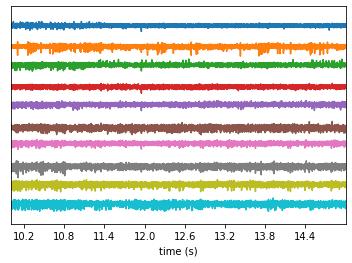

In [35]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[10,15])

In [36]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2500r250a_3500_dir_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/2500r250a_3500_dir_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
 'kwik': '/experiment/z_w12m7_20/sglx/kwik/2020-11-04/2500r250a_3500_dir_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
 'tmp': '/experiment/tmp/tmp/2500r250a_3500_dir_g0',
 'msort': '/experiment/tmp/z_w12m7_20/sglx/msort/2020-11-04/2500r250a_3500_dir_g0',
 'ksort': '/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/4',
 'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/4'}

In [27]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort3',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
    
    elif sorting_method == "kilosort3":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks3')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)
            
        sort = ss.run_kilosort3(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2/3 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [28]:
ss.__version__

'0.4.4'

In [29]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [30]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

#### run the spike sort

In [31]:
ks_params = {'minFR': 0.001,
             'minfr_goodchannels': 0.001}

In [32]:
#sess_par['sort'] = 'auto_5'
#sess_par['sort'] = 'sort_4'
exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [189]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')
tmp_loc = exp_struct['folders']['ksort']
sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=0, 
                     sorting_method='kilosort3', 
                     **ks_params)

2021-10-26 12:25:04,759 root         INFO     Grouping property: None
2021-10-26 12:25:04,761 root         INFO     sorting method: kilosort3
2021-10-26 12:25:04,762 root         INFO     Sorting tmp dir /experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/auto_5/tmp_ks3
2021-10-26 12:25:04,763 root         INFO     Will set visible gpu devices 0
Writing to binary .dat file: 100%|##########| 43/43 [35:52<00:00, 50.05s/it]


KeyboardInterrupt: 

#### load the sort

In [33]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle.dump.pkl')
sort_pickle_path

'/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/sort_4/sort_ks3.pickle.dump.pkl'

In [34]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [35]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [36]:
exp_struct['folders']['ksort']

'/experiment/tmp/z_w12m7_20/sglx/ksort/2020-11-04/2500r250a_3500_dir_g0/sort_4'

In [39]:
clu_df = pd.read_csv(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3', 'cluster_info.tsv'), 
                                sep='\t', header=0)
clu_df.head(1)

cluster_id  Amplitude  ContamPct KSLabel        amp  ch  depth       fr  \
0           0     2070.2      100.0    good  81.407013   6   60.0  1.12206   

  group  n_spikes  sh  
0  good      8575   0

In [41]:
def load_spikes_curated(ks_folder:str) -> tuple:

    spk_dict = {k: np.load(os.path.join(ks_folder, 
                                        'spike_{}.npy'.format(k))).flatten() for k in ['times', 'clusters']}
    
    spk_dict['cluster_id'] = spk_dict['clusters']
    spk_df = pd.DataFrame(spk_dict)
    clu_df = pd.read_csv(os.path.join(ks_folder, 'cluster_info.tsv'), 
                                sep='\t', header=0)
    
    # rename or add manual sorted metadata
    clu_df['main_chan'] = clu_df['ch']
    clu_df['MSLabel'] = clu_df['group']
    
    #clu_df.sort_values(['MSLabel', 'main_chan'], inplace=True)
    spk_df.sort_values(['times'], inplace=True)

    # get the templates
    templ_arr = np.load(os.path.join(ks_folder, 'templates.npy'))
    # Any new clusters created by merging clusters during manually curation will not have a template.
    # They can be identified by the cluster_id number, which is higher than the last cluster_id of the automatic sorting (the ones in template_arr)
    # For any cluster_id > templ_arr.shape[0], fill the template with zeros.
    # Todo: get the missing templates from the temp_wh.dat matrix
    clu_df['has_template'] = clu_df['cluster_id'].apply(lambda x: True if x < templ_arr.shape[0] else False)
    clu_df['template'] = clu_df['cluster_id'].apply(lambda x: templ_arr[x] if x < templ_arr.shape[0] else np.zeros_like(templ_arr[0]))
    
    # with the templates, compute the sorted chanels, main channel, main 7 channels and waveform for the 7 channels
    clu_df['max_chans'] = clu_df['template'].apply(lambda x: np.argsort(np.ptp(x, axis=0))[::-1])
    clu_df['main_chan'] = clu_df['max_chans'].apply(lambda x: x[0])
    
    clu_df['main_7'] = clu_df['max_chans'].apply(lambda x: np.sort(x[:7]))
    clu_df['main_wav_7'] = clu_df.apply(lambda x: x['template'][:, x['max_chans'][:7]], axis=1)
    
    clu_df.sort_values(['MSLabel', 'main_chan'], inplace=True)
    spk_df.sort_values(['times'], inplace=True)


    return clu_df, spk_df

def load_cluster_info(ks_folder: str) -> pd.DataFrame:
    info_df = pd.read_csv(os.path.join(ks_folder, 'cluster_info.tsv'), 
                            sep='\t', header=0)

    return info_df

In [46]:
reload(ks)
#clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
clu_df, spk_df = load_spikes_curated(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))

#info_df = load_cluster_info(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

times  clusters  cluster_id
0     92       148         148

In [63]:
reload(ks)
#clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'), curated=True)

In [82]:
hvc_chans = np.arange(280, 334) #HVC
ra_chans = np.arange(45, 110) #RA
sort_ver = sess_par['sort']                                                           

In [83]:
# try wider range of channels for hvc
#hvc_chans = np.arange(260, 340)

In [84]:
# This should go to the bcistructure
# exp_struct['folders']['ksort'] = os.path.join(exp_struct['folders']['ksort'], sort_ver)
# os.makedirs(exp_struct['folders']['ksort'], exist_ok=True)

In [85]:
## call the HVC/RA sites
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])
#spk_df['mslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['MSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [171]:
clu_df.head(1)

cluster_id  Amplitude  ContamPct KSLabel        amp  ch  depth        fr  \
3           3     2082.9      100.0    good  90.564789   0    0.0  1.104526   

  group  n_spikes  sh  main_chan MSLabel  \
3  good      8441   0          0    good   

                                            template  has_template  \
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...          True   

                                           max_chans                 main_7  \
3  [0, 2, 1, 3, 4, 5, 7, 13, 9, 15, 10, 6, 8, 12,...  [0, 1, 2, 3, 4, 5, 7]   

                                          main_wav_7 nucleus  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....     NaN

In [145]:
clu_df_ra = clu_df[(clu_df['nucleus']=='ra') & (clu_df['MSLabel']=='good')]
np.unique(clu_df_ra['cluster_id']).size

131

In [108]:
# count the mua ones
np.unique(clu_df[clu_df['MSLabel']=='good']['cluster_id']).size

507

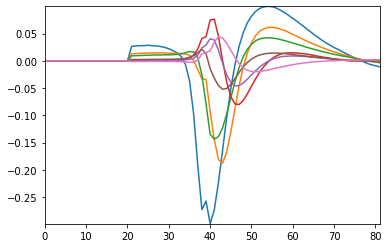

In [130]:
plt.plot(clu_df.loc[80, 'main_wav_7']);

### plot a raster

In [100]:
mot_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12830,   13350,   13872,   14710,   15556,   16436, 7315184,
        7316256, 7317132, 7318041]),
 'len_ms': array([544, 544, 544, 544, 544, 545, 545, 545, 545, 545]),
 'start_sample_naive': array([   320750,    333750,    346800,    367750,    388900,    410900,
        182879600, 182906400, 182928300, 182951025]),
 'start_sample_nidq': array([   320747,    333747,    346797,    367746,    388896,    410896,
        182877527, 182904327, 182926226, 182948951]),
 'start_sample_wav': array([   320751,    333751,    346801,    367751,    388901,    410901,
        182879601, 182906401, 182928301, 182951026]),
 'start_ms_ap_0': array([  12830.21251389,   13350.2387291 ,   13872.21501842,
          14710.21434347,   15556.26436756,   16436.27211803,
        7315266.99595649, 7316338.99532422, 7317214.99361449,
        7318123.98729008]),
 'start_sample_ap_0': array([   384907,    400508, 

### Visualize a bout together with the neural traces

In [144]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu

In [145]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [146]:
mot_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12869,   13391,   13910,   14747,   15593,   16448, 7315206,
        7316284, 7317161, 7318061]),
 'len_ms': array([262, 451, 454, 457, 460, 483, 472, 475, 481, 487]),
 'start_sample_naive': array([   321725,    334775,    347750,    368675,    389825,    411200,
        182880150, 182907100, 182929025, 182951525]),
 'start_sample_nidq': array([   321722,    334772,    347747,    368671,    389821,    411196,
        182878077, 182905027, 182926951, 182949451]),
 'start_sample_wav': array([   321726,    334776,    347751,    368676,    389826,    411201,
        182880151, 182907101, 182929026, 182951526]),
 'start_ms_ap_0': array([  12869.21510283,   13391.23598414,   13910.21754098,
          14747.21186631,   15593.26189041,   16448.27131463,
        7315288.99895529, 7316366.99344962, 7317243.9955396 ,
        7318143.98861774]),
 'start_sample_ap_0': array([   386077,    401738, 

In [147]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [148]:
ap_sf = all_syn_dict['ap_0']['s_f']


### one example of bout onset

In [151]:
hvc_chans = list(range(275, 324)) #HVC
#neur_chans = hvc_chans + ra_chans
neur_chans = ra_chans
neur_chans = hvc_chans

mot_idx = 0

mot_start_wav = mot_dict['start_sample_wav'][mot_idx]
mot_start_ap = mot_dict['start_sample_ap_0'][mot_idx]

pre_sec = -5.25
post_sec = 4 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-152-12a952a9720b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
<ipython-input-152-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


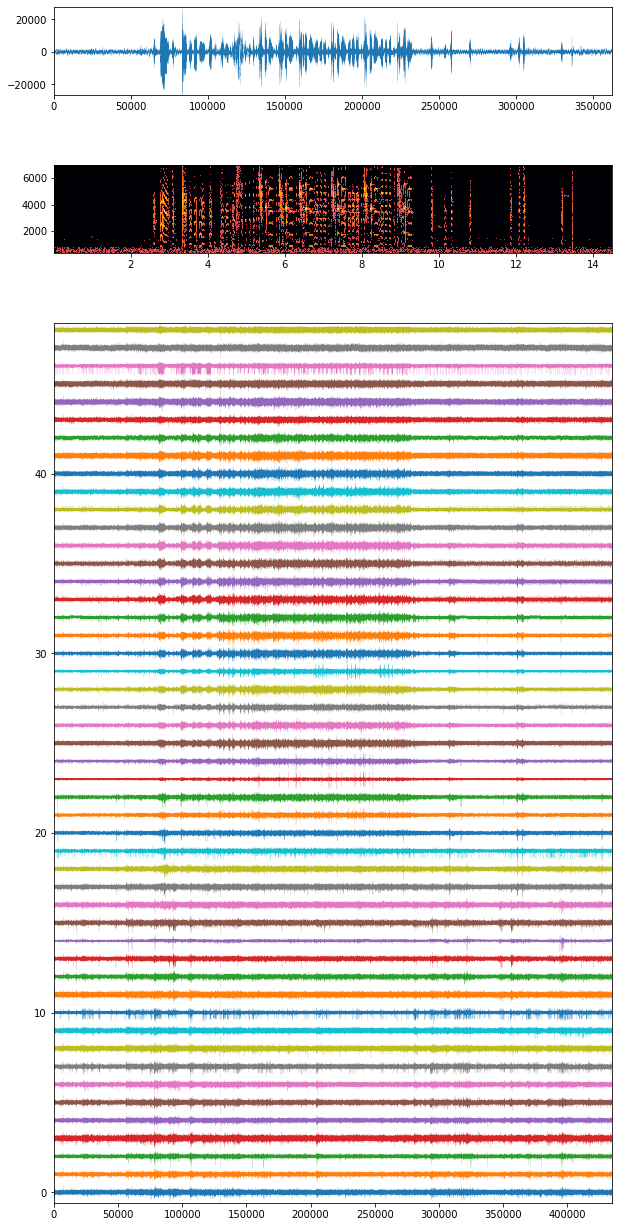

In [152]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

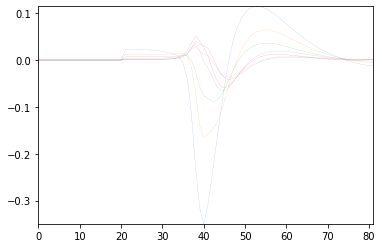

In [174]:
plt.plot(clu_df.loc[125, 'main_wav_7']);

#### check alignment of the syn signals

In [112]:
## have to do it, but it won't be like this
# n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
# ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

# n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
# nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [113]:
# mot_idx = 8
# sec_before = 0
# sec_after = 10

# for mot_idx in range(2):
#     start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
#     end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

#     start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
#     end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

#     fig, ax = plt.subplots(nrows=2)
#     ax[0].plot(ap_syn[start_ap: end_ap], '-*')
#     ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
#     ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [104]:
bout_dict = mot_dict

In [186]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

clu_df_ra = clu_df[(clu_df['nucleus']=='ra') & (clu_df['KSLabel'].isin(['mua', 'good']))]
clu_df_hvc = clu_df[(clu_df['nucleus']=='hvc') & (clu_df['KSLabel'].isin(['mua', 'good']))]

clu_df_hvc = clu_df[(clu_df['nucleus']=='hvc') & (clu_df['KSLabel'].isin(['mua', 'good']))]

clu_list = np.unique(clu_df_hvc['cluster_id'])

t_pre = - 1
t_post = 1

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = get_window_spikes(spk_df, clu_list, start_ap , end_ap)


rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

<ipython-input-186-d4c9a6743a49>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [163]:
clu_list

array([ 900,  909,  912,  914,  916,  918,  919,  922,  923,  924,  926,
        931,  932,  933,  934,  935,  936,  937,  938,  939,  940,  941,
        942,  943,  944,  945,  946,  947,  951,  952,  955,  956,  957,
        958,  959,  961,  962,  964,  965,  966,  967,  969,  970,  972,
        974,  975,  976,  977,  978,  986,  987,  988,  989,  990,  991,
        993,  994,  995,  998,  999, 1000, 1002, 1003, 1004, 1005, 1006,
       1008, 1009, 1010, 1011, 1012, 1013, 1015, 1016, 1017, 1018, 1019,
       1020, 1024, 1025, 1027, 1029, 1031, 1033, 1036, 1038, 1039, 1040,
       1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1051, 1052, 1053,
       1055, 1056, 1057, 1062, 1063, 1065, 1066, 1069, 1070, 1071, 1072,
       1073, 1074, 1075, 1076, 1077, 1079, 1081, 1083, 1084, 1085, 1087,
       1088, 1089, 1090, 1091, 1092, 1094, 1096, 1097, 1098, 1099, 1100,
       1101, 1103, 1104, 1105, 1116, 1118, 1119, 1121])

In [164]:
rast_arr.shape

(140, 60000, 10)

In [210]:
### plot motif-alinged rasters

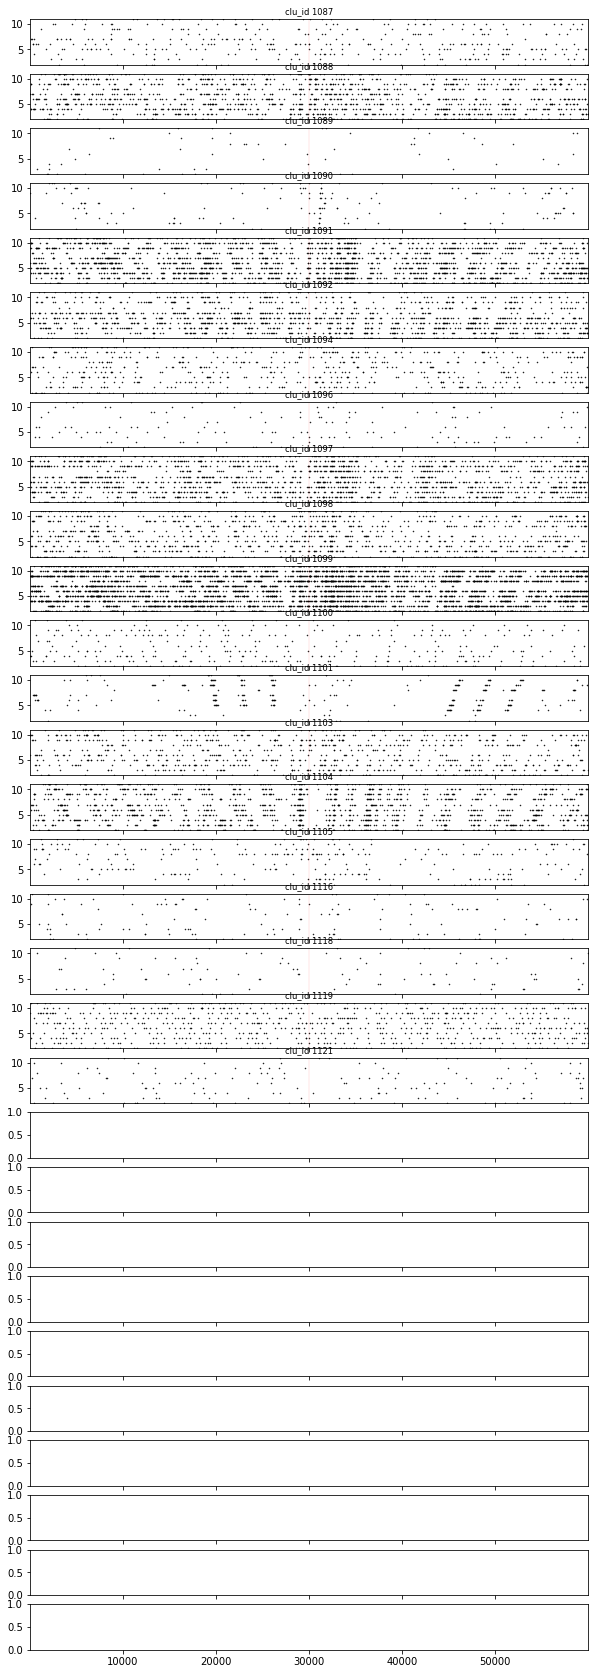

In [169]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=30, figsize=[10, 30], sharex=True)
# ra goes from 80 to 200
for i_rast, clu_idx in enumerate(range(120, 140)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    pu.plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])
    clu_id = clu_list[clu_idx]
    ax_arr[i_rast].set_title('clu_id {}'.format(clu_id))

In [171]:
# hand classification of hvc by rasters
# clu_id corresopnds to 'int': interneuron~ish; 'sharp': sharply modulated int; 'blur': blurrily modulated int; 'pn': sparse, sharp pn-like
hvc_meta_dict = {}
hvc_meta_dict['int'] = [913, 922, 923, 934, 951, 989, 998, 1002, 1003, 1036, 1038, 1044, 1045, 1077, 1080, 1083, 1084, 1085, 1087, 1094, 1095, 1097, 1103, 1105, 1116, 1119, 1121]
hvc_meta_dict['blur'] = [1031, 1033, 1038, 1044, 1045, 1046, 1051, 1051, 1052, 1056, 1066, 1070, 1077, 1083, 1087, 1094, 1100, 1103, 1105, 1119]
hvc_meta_dict['sharp'] = [976, 1019, 1048, 1062, 1063, 1064, 1065, 1071, 1072, 1074, 1075, 1076, 1088, 1091, 1092, 1097, 1098, 1099, 1104]
hvc_meta_dict['pn'] = [1016, 1020, 1025, 1026, 1039, 1047, 1049, 1050, 1055, 1057, 1073, 1078, 1079, 1090, 1101]

meta_dict_path = os.path.join(sort_folder, 'hvc_meta_dict.pkl')
logger.info('saving the hvc meta dict to {}'.format(meta_dict_path))
with open(meta_dict_path, 'wb') as f:
    pickle.dump(hvc_meta_dict, f)
logger.info('saved')

2021-11-01 01:59:26,194 root         INFO     saving the hvc meta dict to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/hvc_meta_dict.pkl
2021-11-01 01:59:26,202 root         INFO     saved


### Collect all bouts for all clusters and make a dataframe

In [187]:
def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

In [219]:
mot_dict['start_sample_ap_0']

array([   384907,    400508,    416167,    441307,    466689,    493089,
       219458073, 219490233, 219516513, 219543782])

In [241]:
rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

<ipython-input-231-ad1aa76affff>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [221]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12830,   13350,   13872,   14710,   15556,   16436, 7315184,
        7316256, 7317132, 7318041]),
 'len_ms': array([544, 544, 544, 544, 544, 545, 545, 545, 545, 545]),
 'start_sample_naive': array([   320750,    333750,    346800,    367750,    388900,    410900,
        182879600, 182906400, 182928300, 182951025]),
 'start_sample_nidq': array([   320747,    333747,    346797,    367746,    388896,    410896,
        182877527, 182904327, 182926226, 182948951]),
 'start_sample_wav': array([   320751,    333751,    346801,    367751,    388901,    410901,
        182879601, 182906401, 182928301, 182951026]),
 'start_ms_ap_0': array([  12830.21251389,   13350.2387291 ,   13872.21501842,
          14710.21434347,   15556.26436756,   16436.27211803,
        7315266.99595649, 7316338.99532422, 7317214.99361449,
        7318123.98729008]),
 'start_sample_ap_0': array([   384907,    400508, 

In [188]:
spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = -5
t_post = 5

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list).astype(np.int16))
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
bout_dict['t_pre_s'] = t_pre
bout_dict['t_post_s'] = t_post

keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

<ipython-input-186-d4c9a6743a49>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


start_sample_nidq  start_sample_ap_0  len_ms  \
0             321722             386077     451   
1             334772             401738     451   
2             347747             417307     454   
3             368671             442417     457   
4             389821             467798     460   

                                             spk_arr  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             mic_arr  \
0  [-331, -528, -120, -150, -204, -22, 353, 377, ...   
1  [-636, -601, -887, -940, -792, -1126, -1216, -...   
2  [366, 258, 9, 270, 302, 400, 708, 791, 684, 57...   
3  [-515, -554, -651, -317, -420, -333, -239, -28...   
4  [2433, 4521, 4177, 1790, -601, -1393, -951, -8...   

                                          clu_id_arr  
0  [900, 909, 912, 913, 914, 916, 917, 918, 919, ...  
1  [900, 909, 912, 913, 914, 916, 917, 918, 919, ...  
2  [900, 909, 912, 913, 914, 916, 917, 918, 919, ...  
3  [900, 909, 912, 913, 914, 916, 917, 918, 919, ...  
4  [900, 909, 912, 913, 914, 916, 917, 918, 919, ...

In [243]:
bout_dict['spk_arr'][0].shape

(146, 300000)

In [203]:
np.stack(bout_dict['spk_arr'], axis=0).shape

(10, 1151, 300000)

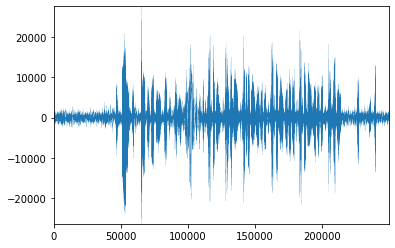

In [184]:
plt.plot(bout_df.loc[1, 'mic_arr'])

### save all to derived data

In [189]:
reload(et)
reload(sglu)
exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [190]:
sort_folder = os.path.join(exp_struct['folders']['sort'])
os.makedirs(sort_folder, exist_ok=True)

In [191]:
bout_dict_path = os.path.join(sort_folder, 'bout_dict_hvc_allunits.pkl')
logger.info('saving the bout dataframe to {}'.format(bout_dict_path))
with open(bout_dict_path, 'wb') as f:
    pickle.dump(bout_dict, f)
logger.info('saved')

# save the spk_df, clu_df as well


2021-11-01 03:36:27,188 root         INFO     saving the bout dataframe to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/bout_dict_hvc_allunits.pkl
2021-11-01 03:36:37,701 root         INFO     saved


In [192]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.716529250098,
 's_f_ap_0': 30000.008506739956,
 'start_ms': array([  12869,   13391,   13910,   14747,   15593,   16448, 7315206,
        7316284, 7317161, 7318061]),
 'len_ms': array([451, 451, 454, 457, 460, 483, 472, 475, 481, 487]),
 'start_sample_naive': array([   321725,    334775,    347750,    368675,    389825,    411200,
        182880150, 182907100, 182929025, 182951525]),
 'start_sample_nidq': array([   321722,    334772,    347747,    368671,    389821,    411196,
        182878077, 182905027, 182926951, 182949451]),
 'start_sample_wav': array([   321726,    334776,    347751,    368676,    389826,    411201,
        182880151, 182907101, 182929026, 182951526]),
 'start_ms_ap_0': array([  12869.21510283,   13391.23598414,   13910.21754098,
          14747.21186631,   15593.26189041,   16448.27131463,
        7315288.99895529, 7316366.99344962, 7317243.9955396 ,
        7318143.98861774]),
 'start_sample_ap_0': array([   386077,    401738, 

In [123]:
### save to pickle
spike_pickle_path = os.path.join(sort_folder, 'spk_df.pickle')
clu_pickle_path = os.path.join(sort_folder, 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

<ipython-input-118-5e35dff3398e>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
<ipython-input-122-3c007160f8cc>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


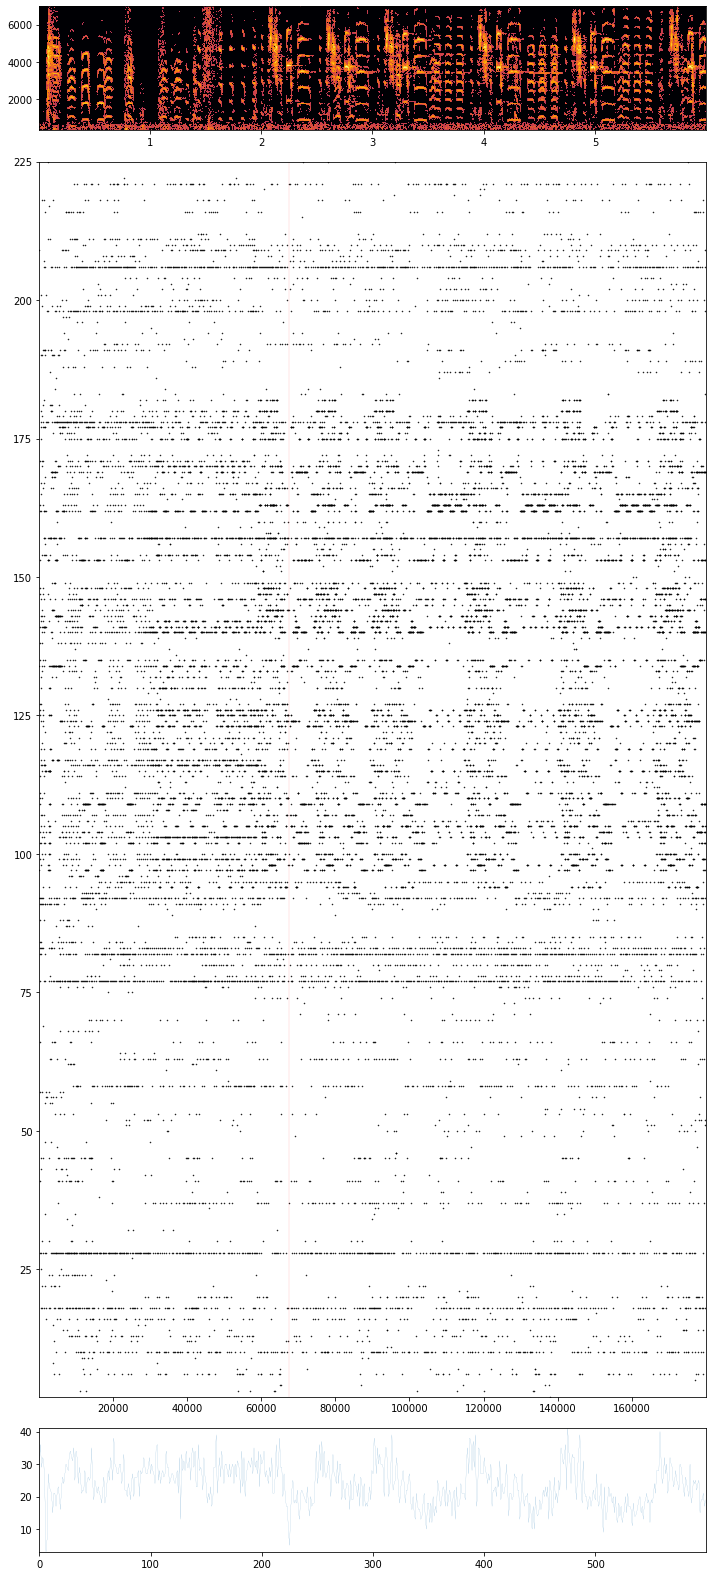

In [122]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 3
t_post = 3

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [123]:
from ceciestunepipe.util import plotutil as pu

In [124]:
bin_size_sample

300

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


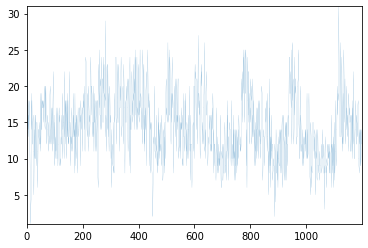

In [125]:
# plot a 'psth' of the summed activity of all units
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'] )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

plt.plot(psth);

In [161]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### NOw same one for MUA

<ipython-input-118-5e35dff3398e>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
<ipython-input-126-19593720e079>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


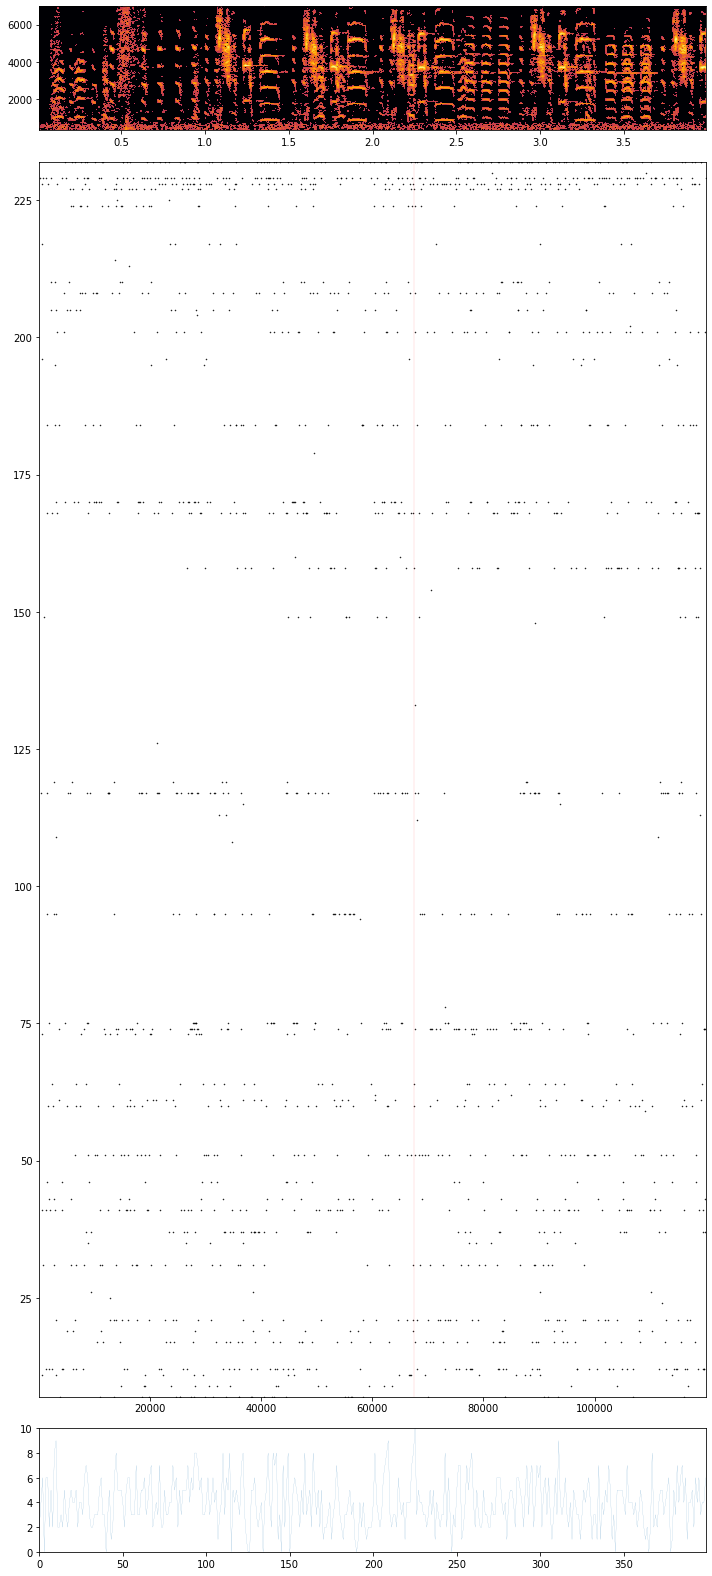

In [126]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 2
t_post = 2

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [164]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

In [211]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1-complete-mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster, motif and cluster metadata

In [212]:
import pickle

In [131]:
sort_version = 'sort_{}'.format(str(sess_par['sort']))
os.makedirs(os.path.join(exp_struct['folders']['derived'],sort_version), exist_ok=True)

clu_df_path = os.path.join(exp_struct['folders']['derived'],sort_version , 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['derived'], sort_version, 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['derived'], sort_version, 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

logger.info('saved sort files to {}'.format(os.path.join(exp_struct['folders']['derived'],sort_version)))

2021-10-20 04:02:11,942 root         INFO     saved sort files to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4


In [174]:
exp_struct['folders']['processed']

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0'

In [161]:
bin_spk_arr.shape

(169, 1250)